In [158]:
from functions import *

In [159]:
T = 0.5
n = 6
scope = 'zoomed'

In [160]:
# NOTE: We evaluate the algorithm on the SAME 10 random instances for each grid point

# Grid search

In [161]:
if scope == 'zoomed':
    # Zoomed in search
    gamma_lims = (0,1) # Range of gamma values
    gamma_steps = 50
    time_lims = (0,20) # Range of time values
    time_steps = 50
elif scope == 'broad':
    # Broad search
    gamma_lims = (0.2,3) # Range of gamma values
    gamma_steps = 50
    time_lims = (0,100) # Range of time values
    time_steps = 50
elif scope == 'custom':
    gamma_lims = (0,20) 
    gamma_steps = 500 
    time_lims = (0,300) 
    time_steps = 500 

gamma_range = np.linspace(gamma_lims[0], gamma_lims[1], gamma_steps)
time_range = np.linspace(time_lims[0], time_lims[1], time_steps)

num_random_models = 10

def f(t):
    '''
    Calculate spectral gaps for quantum and mismatched proposals.
    f(t) is defined to parallelize the time-loop.
    '''    
    delta_quantum_arr = np.zeros((gamma_steps, num_random_models))
    delta_mismatched_quantum_arr = np.zeros((gamma_steps, num_random_models))
    for gamma_id, gamma in enumerate(gamma_range):
        np.random.seed(0) # set the seed for reproducibility
        for i in range(num_random_models):
            m = RandomIsingModel(n)
            # Calculate delta for quantum proposal
            proposal_mat_quantum = get_proposal_mat_quantum(m, gamma, t)
            P_quantum = get_transition_matrix(m, T, proposal_mat_quantum)
            delta_quantum = get_delta(P_quantum)
            delta_quantum_arr[gamma_id, i] = delta_quantum
            # Calculate delta for mismatched quantum proposal
            m_mismatched = RandomIsingModel(n)
            proposal_mat_mismatched_quantum = get_proposal_mat_quantum(m_mismatched, gamma, t)
            P_mismatched_quantum = get_transition_matrix(m, T, proposal_mat_mismatched_quantum)
            delta_mismatched_quantum = get_delta(P_mismatched_quantum)
            delta_mismatched_quantum_arr[gamma_id, i] = delta_mismatched_quantum
    return delta_quantum_arr, delta_mismatched_quantum_arr

In [162]:
sweep_data = np.asarray(joblib.Parallel(n_jobs=-1)(joblib.delayed(f)(t) for t in tqdm(time_range)))
sweep_data = sweep_data.swapaxes(0,1)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


In [163]:
delta_quantum_arr = sweep_data[0]
delta_mismatched_quantum_arr = sweep_data[1]

# Save the data

In [164]:
# grid_search = {'quantum': delta_quantum_arr,
#                'mismatched': delta_mismatched_quantum_arr}

# if scope == 'zoomed':
#     pickle.dump(grid_search, open(f'data/grid_search_zoomed_n{n}.p','wb'))
# elif scope == 'broad':
#     pickle.dump(grid_search, open(f'data/grid_search_n{n}.p','wb'))
# elif scope == 'custom':
#     pickle.dump(grid_search, open(f'data/grid_search_custom_n{n}.p','wb'))

In [165]:
# grid_search = pickle.load(open('data/grid_search_n{n}.p','rb'))
# delta_quantum_arr = grid_search['quantum']
# delta_mismatched_quantum_arr = grid_search['mismatched']

# Average and plot the results

In [166]:
delta_quantum_arr_avg = np.mean(delta_quantum_arr, axis=2)
delta_quantum_arr_std = np.std(delta_quantum_arr, axis=2)

delta_mismatched_quantum_arr_avg = np.mean(delta_mismatched_quantum_arr, axis=2)
delta_mismatched_quantum_arr_std = np.std(delta_mismatched_quantum_arr, axis=2)

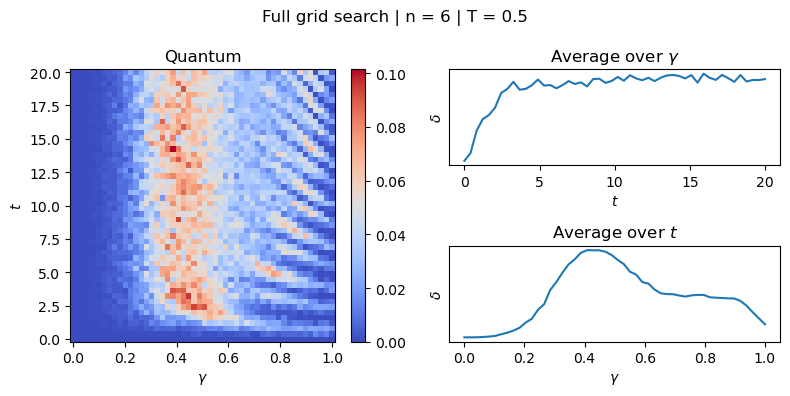

In [167]:
fig, axs = plt.subplot_mosaic([['left', 'upper right'],
                               ['left', 'lower right']],
                              figsize=(8, 4),
                              width_ratios=[2,2])
fig.suptitle(f'Full grid search | n = {n} | T = {T}')

pc0 = axs['left'].pcolor(gamma_range,
                         time_range, 
                         delta_quantum_arr_avg, 
                         cmap='coolwarm',
                         vmin=0,
                         vmax=np.max(delta_quantum_arr_avg)
                         )
fig.colorbar(pc0, ax=axs['left'])

axs['left'].set_xlabel('$\gamma$')
axs['left'].set_ylabel('$t$')
axs['left'].set_title('Quantum')

# axs['left'].set_yscale('log')
# axs['left'].set_xscale('log')

axs['upper right'].plot(time_range, np.mean(delta_quantum_arr_avg, axis=1))
axs['upper right'].set_xlabel('$t$')
axs['upper right'].set_ylabel('$\delta$')
axs['upper right'].set_yticks([])
axs['upper right'].set_title('Average over $\gamma$')

axs['lower right'].plot(gamma_range, np.mean(delta_quantum_arr_avg, axis=0))
axs['lower right'].set_xlabel('$\gamma$')
axs['lower right'].set_ylabel('$\delta$')
axs['lower right'].set_yticks([])
axs['lower right'].set_title('Average over $t$')

fig.tight_layout()

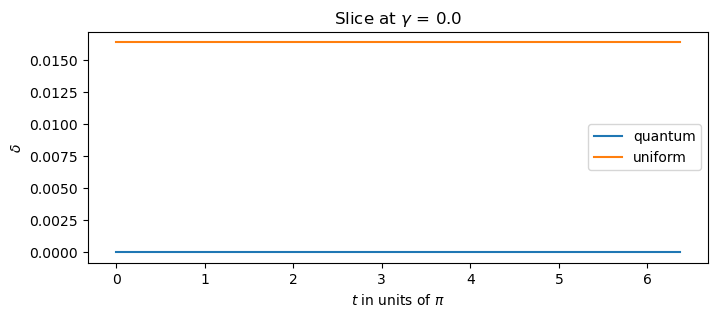

In [168]:
np.random.seed(0)
m = RandomIsingModel(n)

proposal_mat_random = get_proposal_mat_random(m)
P_random = get_transition_matrix(m, T, proposal_mat_random)
delta_random = get_delta(P_random)

plt.figure(figsize=(8,3))
plt.plot(time_range[:] / np.pi, delta_quantum_arr_avg[:, 0][:], label='quantum')
plt.plot(time_range / np.pi, np.ones_like(time_range)*delta_random, label='uniform')
plt.ylabel('$\delta$')
plt.xlabel('$t$ in units of $\pi$')
plt.title(f'Slice at $\gamma$ = {gamma_range[0]}')
plt.legend()

In [169]:
i,j = divmod(np.argmax(delta_quantum_arr_avg), delta_quantum_arr_avg.shape[1])
t_opt = time_range[i]
gamma_opt = gamma_range[j]
print(f'Highest spectral gap achieved at t = {t_opt} and gamma = {gamma_opt}.')

Highest spectral gap achieved at t = 14.285714285714286 and gamma = 0.3877551020408163.


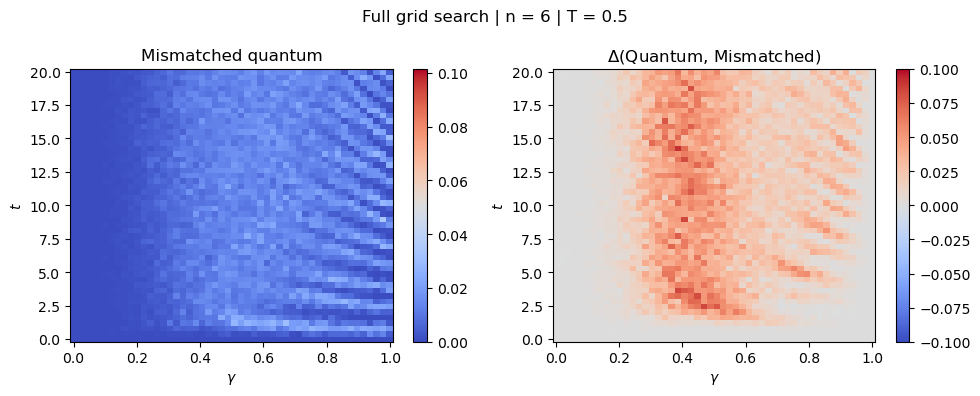

In [170]:
fig, axs = plt.subplots(1,2, figsize=(10, 4))
fig.suptitle(f'Full grid search | n = {n} | T = {T}')

pc0 = axs[0].pcolor(gamma_range, 
                    time_range, 
                    delta_mismatched_quantum_arr_avg, 
                    cmap='coolwarm',
                    vmin=0,
                    vmax=np.max(delta_quantum_arr_avg)
                    )
fig.colorbar(pc0, ax=axs[0])

pc1 = axs[1].pcolor(gamma_range, 
                    time_range, 
                    delta_quantum_arr_avg - delta_mismatched_quantum_arr_avg, 
                    cmap='coolwarm',
                    vmin=-0.1,
                    vmax=0.1
                    )
fig.colorbar(pc1, ax=axs[1])

axs[0].set_ylabel('$t$')
axs[0].set_xlabel('$\gamma$')
axs[0].set_title('Mismatched quantum')

axs[1].set_ylabel('$t$')
axs[1].set_xlabel('$\gamma$')
axs[1].set_title('$\Delta$(Quantum, Mismatched)')

fig.tight_layout()